# Chapter 6 - Semantic Analysis – Meaning Matters

의미 분석 - 본질의 표현 찾기

In [1]:
# NER
# HMM을 사용한 NER 시스템
# 기계 학습툴킷을 사용한 NER 훈련
# POS 태깅을 사용한 NER 
# Wordnet에서 synset if의 생성
# Wordnet을 사용한 의미 판별

<br></br>
## 1 Introducing semantic analysis
의미분석 : 문장을 공식을 활용하여, 명제기호로 표현 (P,Q,R...)

In [2]:
# 의미분석 : 데이터베이스를 질의하고, 정보를 검색
# Gensim : 문서 indexing, 주제 modeling, 유사성 검색을 수행
# polyglot : 다국어를 지원하는 NLP 도구로 40개 언어를 지원한다

# P  : It is raining. (원인문장)
# Q  : I'll wear raincoat. (결과문장)
# P→Q: If it is raining, I'll wear a raincoat.(원인 -> 결과)

### 01 Introduction
기본 연산함수 내용정리

In [3]:
# Boolean로 사용가능한 연산자를 출력
import nltk
nltk.boolean_ops()

negation       	-
conjunction    	&
disjunction    	|
implication    	->
equivalence    	<->


In [4]:
# Well formed Formulas : 명제기호나, 명제 기호와 Boolean 연산의 조합을 활용
import nltk
input_expr = nltk.sem.Expression.fromstring
print(input_expr('X | (Y -> Z)'))
print(input_expr('-(X & Y)'))
print(input_expr('X & Y'))
print(input_expr('X <-> -- X'))

(X | (Y -> Z))
-(X & Y)
(X & Y)
(X <-> --X)


In [5]:
# 논리 표현식에 True/ False 값을 매핑
import nltk
value = nltk.Valuation([('X', True), ('Y', False), ('Z', True)])
print(value['Z'])
domain = set()
v = nltk.Assignment(domain)
u = nltk.Model(domain, value)
print(u.evaluate('(X & Y)', v))
print(u.evaluate('-(X & Y)', v))
print(u.evaluate('(X & Z)', v))
print(u.evaluate('(X | Y)', v))

True
False
True
True
True


In [6]:
# NLTK의 상수 및 술어를 포함하는 1차 술어논리를 구현
import nltk
input_expr = nltk.sem.Expression.fromstring
expression = input_expr('run(marcus)', type_check=True)
print(expression.argument)
print(expression.argument.type)
print(expression.function)
print(expression.function.type)

marcus
e
run
<e,?>


In [7]:
sign = {'run': '<e, t>'}
expression = input_expr('run(marcus)', signature=sign)
print(expression.function.type)

e


In [8]:
# Signature는 연관유형 및 비논리 상수를 매핑

import nltk
nltk.data.show_cfg('grammars/book_grammars/sql1.fcfg')

% start S
S[SEM=(?np + WHERE + ?vp)] -> NP[SEM=?np] VP[SEM=?vp]
VP[SEM=(?v + ?pp)] -> IV[SEM=?v] PP[SEM=?pp]
VP[SEM=(?v + ?ap)] -> IV[SEM=?v] AP[SEM=?ap]
VP[SEM=(?v + ?np)] -> TV[SEM=?v] NP[SEM=?np]
VP[SEM=(?vp1 + ?c + ?vp2)] -> VP[SEM=?vp1] Conj[SEM=?c] VP[SEM=?vp2]
NP[SEM=(?det + ?n)] -> Det[SEM=?det] N[SEM=?n]
NP[SEM=(?n + ?pp)]  -> N[SEM=?n] PP[SEM=?pp]
NP[SEM=?n]  -> N[SEM=?n]  | CardN[SEM=?n] 
CardN[SEM='1000'] -> '1,000,000' 
PP[SEM=(?p + ?np)] -> P[SEM=?p] NP[SEM=?np]
AP[SEM=?pp] -> A[SEM=?a] PP[SEM=?pp]
NP[SEM='Country="greece"'] -> 'Greece'
NP[SEM='Country="china"'] -> 'China'
Det[SEM='SELECT'] -> 'Which' | 'What'
Conj[SEM='AND'] -> 'and'
N[SEM='City FROM city_table'] -> 'cities'
N[SEM='Population'] -> 'populations'
IV[SEM=''] -> 'are'
TV[SEM=''] -> 'have'
A -> 'located'
P[SEM=''] -> 'in'
P[SEM='>'] -> 'above'


In [9]:
from nltk import load_parser
test = load_parser('grammars/book_grammars/sql1.fcfg')
q = " What cities are in Greece"
t = list(test.parse(q.split()))
ans = t[0].label()['SEM']
ans = [s for s in ans if s]
q = ' '.join(ans)
print(q)

SELECT City FROM city_table WHERE Country="greece"


In [10]:
from nltk.sem import chat80
r = chat80.sql_query('corpora/city_database/city.db', q)
for p in r:
    print(p[0], end=" ")

athens 

### 02 NER 소개
Named Entity Recognition : 고유명사, 개체명이 문서에 위치하는 과정

In [11]:
#    SNO  Named entity tag Meaning
# 01 NEP  Name of Person
# 02 NED  Name of Designation
# 03 NEO  Name of Organization
# 04 NEA  Name of Abbreviation
# 05 NEB  Name of Brand
# 06 NETP Title of Person
# 07 NETO Title of Object
# 08 NEL  Name of Location
# 09 NETI Time
# 10 NEN  Number
# 11 NEM  Measure
# 12 NETE Terms

In [12]:
# nltk에서 튜플로(entity, relation, entity) 저장한 뒤, 'entity'값을 검색한다
locations=[('Jaipur', 'IN', 'Rajasthan'),('Ajmer', 'IN', 'Rajasthan'),
           ('UdaipurIN', 'IN','Rajasthan'),('Mumbai', 'IN', 'Maharashtra'),
           ('Ahmedabad', 'IN', 'Gujrat')]

q = [x1     for (x1, relation, x2) in locations     if x2 == 'Rajasthan']
q

['Jaipur', 'Ajmer', 'UdaipurIN']

In [13]:
# NER을 수행하기 위한, '스탠포드 tagger'를 활용한다

from nltk.tag import StanfordNERTagger
# sentence = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')  # Lookup Error가 발생한다
# sentence.tag('John goes to NY'.split())

In [14]:
# 개체명이 존재할 경우, 이를 감지하고 'NE'태그로 tag를 지정
import nltk
sentences1 = nltk.corpus.treebank.tagged_sents()[17]
print(nltk.ne_chunk(sentences1, binary=True))

(S
  The/DT
  total/NN
  of/IN
  18/CD
  deaths/NNS
  from/IN
  malignant/JJ
  mesothelioma/NN
  ,/,
  lung/NN
  cancer/NN
  and/CC
  asbestosis/NN
  was/VBD
  far/RB
  higher/JJR
  than/IN
  */-NONE-
  expected/VBN
  *?*/-NONE-
  ,/,
  the/DT
  researchers/NNS
  said/VBD
  0/-NONE-
  *T*-1/-NONE-
  ./.)


In [15]:
sentences2 = nltk.corpus.treebank.tagged_sents()[7]
print(nltk.ne_chunk(sentences2, binary=True))

(S
  A/DT
  (NE Lorillard/NNP)
  spokewoman/NN
  said/VBD
  ,/,
  ``/``
  This/DT
  is/VBZ
  an/DT
  old/JJ
  story/NN
  ./.)


In [16]:
print(nltk.ne_chunk(sentences2))

(S
  A/DT
  (ORGANIZATION Lorillard/NNP)
  spokewoman/NN
  said/VBD
  ,/,
  ``/``
  This/DT
  is/VBZ
  an/DT
  old/JJ
  story/NN
  ./.)


In [17]:
# 개체명을 감지하는 nltk를 다른예제로 수행

import nltk
from nltk.corpus import conll2002
for documents in conll2002.chunked_sents('ned.train')[25]:
    print(documents)

(PER Vandenbussche/Adj)
('zelf', 'Pron')
('besloot', 'V')
('dat', 'Conj')
('het', 'Art')
('hof', 'N')
('"', 'Punc')
('de', 'Art')
('politieke', 'Adj')
('zeden', 'N')
('uit', 'Prep')
('het', 'Art')
('verleden', 'N')
('"', 'Punc')
('heeft', 'V')
('willen', 'V')
('veroordelen', 'V')
('.', 'Punc')


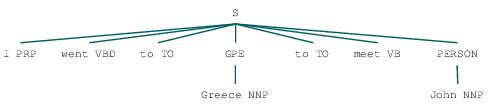

In [18]:
# chunk는 plain text를 의미상 관련된 순서로 분할하는데 사용
# 영어, 네델란드어, 스페인어, 포르투갈어를 활용가능하다

import nltk
sentence = "I went to Greece to meet John"
tok = nltk.word_tokenize(sentence)
pos_tag = nltk.pos_tag(tok)
nltk.ne_chunk(pos_tag)

### 03 은닉 마르코프 모델을 사용한 NER 시스템
Named Entity Recognition : 고유명사, 개체명이 문서에 위치하는 과정

In [19]:
# HMM은 확률분포와 관련된 유한집함으로 구성된 Stochastic Finite State Automaton로 정의된다
# HMM은 '마르코프 체인'속성에 따라, 이전 tag의 확률에 따라 값이 변하므로
# 단점은 많은 훈련과 의존성이 따르지만
# 장점은 간단한 방법으로도 가능하다

In [20]:
# HMM을 사용해서 NER을 수행하는 Annotation, HMM train, HMM test 단계를 거친다

import nltk
nltk.tag.hmm.demo_pos()


HMM POS tagging demo

Training HMM...
Testing...
Test: the/AT fulton/NP county/NN grand/JJ jury/NN said/VBD friday/NR an/AT investigation/NN of/IN atlanta's/NP$ recent/JJ primary/NN election/NN produced/VBD ``/`` no/AT evidence/NN ''/'' that/CS any/DTI irregularities/NNS took/VBD place/NN ./.

Untagged: the fulton county grand jury said friday an investigation of atlanta's recent primary election produced `` no evidence '' that any irregularities took place .

HMM-tagged: the/AT fulton/NP county/NN grand/JJ jury/NN said/VBD friday/NR an/AT investigation/NN of/IN atlanta's/NP$ recent/JJ primary/NN election/NN produced/VBD ``/`` no/AT evidence/NN ''/'' that/CS any/DTI irregularities/NNS took/VBD place/NN ./.

Entropy: 18.7331739705

------------------------------------------------------------
Test: the/AT jury/NN further/RBR said/VBD in/IN term-end/NN presentments/NNS that/CS the/AT city/NN executive/JJ committee/NN ,/, which/WDT had/HVD over-all/JJ charge/NN of/IN the/AT election/NN ,/

In [21]:
# NER tagger의 결과는 response 와 answer key로써 인간의 해석으로 정의가 가능하다
# 1 Correct(일치) : 응답이 대답키와 정확히 일치
# 2 Incorrect(불일치) : 응답이 대답키와 같지 않은경우
# 3 Missing (실종) : 응답 tag 미지정, 대답 tag 지정
# 4 Spurious(가짜) : 응답 tag 지정, 대답 tag 미지정

In [22]:
# NER 기반 시스템의 성능평가
# 1 Precision (P) : 정확도 측정
#   P = Correct / ( Correct + Incorrect + Missing )
# 2 Recall (R) 
#   R = Correct / ( Correct + Incorrect + Spurious )
# 3 F-Measure
#   F-Measure = (2 * PREC * REC) / (PRE + REC)

### 04 기계학습 툴킷을 사용한 NER 훈련
NER의 수행

In [23]:
# 1 규칙 기반 혹은 수동 접근
#   리스트 look up 접근
#   언어 접근

# 2 기계학습 기반 접근, 혹은 자동화된 접근
#   은닉 마르코프 모델
#   최대 엔트로피 마르코프 모델
#   조건부 임의 필드
#   SVM (서포트 벡터 머신)
#   Decision Tree

# 기계학습 기반이 규칙기반에 비해 성능이 더 좋다, 
# 규칙기반과 기계학습을 함께 사용하면 최적의 NER을 잘 찾을 수 있다

### 05 POS 태깅을 사용한 NER
형태소 분석기 (Pos tagging)의 tag 목록

https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [24]:
# POS 태깅을 사용해 NER을 수해한다
import nltk
from nltk import pos_tag, word_tokenize
pos_tag(word_tokenize("John and Smith are going to NY and Germany"))

[('John', 'NNP'),
 ('and', 'CC'),
 ('Smith', 'NNP'),
 ('are', 'VBP'),
 ('going', 'VBG'),
 ('to', 'TO'),
 ('NY', 'NNP'),
 ('and', 'CC'),
 ('Germany', 'NNP')]

In [25]:
# NLTK에서 POS 태깅이 수행되고, POS태그 정보가 객체명을 검색하는 예제
import nltk
from nltk.corpus import brown
from nltk.tag import UnigramTagger
tagger = UnigramTagger(brown.tagged_sents(categories='news')[:700])

sentence = ['John','and','Smith','went','to','NY','and','Germany']
for word, tag in tagger.tag(sentence):
    print(word,'->',tag)

John -> NP
and -> CC
Smith -> None
went -> VBD
to -> TO
NY -> None
and -> CC
Germany -> None


In [26]:
# 결과
# John은 NP로 태깅되어 개체명이 식별되고, 일부 DB에 없는 내용은 None으로 tag가 지정된다

<br></br>
## 2 Wordnet의 synset id 생성
Wordnet은 영어어휘 DB로 정의가 가능하다

상위어, 동의어, 반의어 및 하위어 같은 개념의존성을 synsets를 사용해서 찾을 수 있다

In [27]:
# synsets : Wordnet중 '영어'의 단어 묶음을 synsets으로 명명한다
# Iterate over all synsets with a given part of speech tag.
# If no pos is specified, all synsets for all parts of speech
# will be loaded.

In [28]:
# 주어진 품사tag로 sunsets을 반복한다, POS를 지정하지 않으면 sunsets이 로드된다
def all_synsets(self, pos=None):
    if pos is None:
        pos_tags = self._FILEMAP.keys()
    else:
        pos_tags = [pos]
        cache = self._synset_offset_cache
        from_pos_and_line = self._synset_from_pos_and_line
        for pos_tag in pos_tags:  # 각 품사에 대한 synsets을 생성
        # self._data_file_map 에 포함된 file poitners들은 재사용이 불가능하다
            if pos_tag == ADJ_SAT:
                pos_tag = ADJ
                fileid = 'data.%s' % self._FILEMAP[pos_tag]
                data_file = self.open(fileid)
                try:
                    offset = data_file.tell() # POS 파일에 각 행에 대한 synset을 생성 
                    line = data_file.readline()
                    while line:
                        if not line[0].isspace():
                            if offset in cache[pos_tag]:
                                synset = cache[pos_tag][offset] # synset 이 캐시에 로드를 확인
                            else: # 로드되지 않을떄, line을 파싱한다
                                synset = from_pos_and_line(pos_tag, line)
                                cache[pos_tag][offset] = synset
                        # satellites은 형용사로 파일에 포함되어 있다, satellite은 synset을 생성한다
                        if synset._pos == ADJ_SAT: yield synset
                        else: yield synset # 기타 다른 POS태그는 모든 synsets을 얻는다
                    offset = data_file.tell()
                    line = data_file.readline()
                except:      # 오픈한 여분의 파일 핸들을 닫는다
                    data_file.close()
                    raise
        else: data_file.close()

In [29]:
# synsets를 사용해 단어를 검색하는데 사용
import nltk
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
wn.synsets('cat')

[Synset('cat.n.01'),
 Synset('guy.n.01'),
 Synset('cat.n.03'),
 Synset('kat.n.01'),
 Synset('cat-o'-nine-tails.n.01'),
 Synset('caterpillar.n.02'),
 Synset('big_cat.n.01'),
 Synset('computerized_tomography.n.01'),
 Synset('cat.v.01'),
 Synset('vomit.v.01')]

In [30]:
wn.synsets('cat', pos=wn.VERB)

[Synset('cat.v.01'), Synset('vomit.v.01')]

In [31]:
wn.synset('cat.n.01')

Synset('cat.n.01')

In [32]:
# cat.n.01 은 cat 명사범주에 속하며, cat의 의미가 하나면 존재함을 의미
print(wn.synset('cat.n.01').definition())
len(wn.synset('cat.n.01').examples())

feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats


0

In [33]:
wn.synset('cat.n.01').lemmas()

[Lemma('cat.n.01.cat'), Lemma('cat.n.01.true_cat')]

In [34]:
[str(lemma.name()) for lemma in wn.synset('cat.n.01').lemmas()]

['cat', 'true_cat']

In [35]:
wn.lemma('cat.n.01.cat').synset()

Synset('cat.n.01')

In [36]:
# nltk ISO 639 언어코드를 사용한 Sunsets 
# 및 오픈 다중 언어의 사용하는 코딩
import nltk
from nltk.corpus import wordnet
from nltk.corpus import wordnet as wn
sorted(wn.langs()[::4])

['cat', 'eng', 'eus', 'glg', 'ita', 'pol', 'spa']

In [37]:
wn.synset('cat.n.01').lemma_names('ita')

['gatto']

In [38]:
sorted(wn.synset('cat.n.01').lemmas('dan'))

[Lemma('cat.n.01.kat'), Lemma('cat.n.01.mis'), Lemma('cat.n.01.missekat')]

In [39]:
sorted(wn.synset('cat.n.01').lemmas('por'))

[Lemma('cat.n.01.Gato-doméstico'),
 Lemma('cat.n.01.Gato_doméstico'),
 Lemma('cat.n.01.bichano'),
 Lemma('cat.n.01.gata'),
 Lemma('cat.n.01.gato'),
 Lemma('cat.n.01.gato-doméstico')]

In [40]:
len(wordnet.all_lemma_names(pos='n', lang='jpn'))

64797

In [41]:
cat = wn.synset('cat.n.01')
cat.hypernyms()

[Synset('feline.n.01')]

In [42]:
cat.hyponyms()

[Synset('domestic_cat.n.01'), Synset('wildcat.n.03')]

<br></br>
## 3 Wordnet을 사용한 의미판별
의미판별을 위해, Sense(감각) 혹은 의미(meaning)에 기초하여, 둘 이상의 동일한 철자 혹은 동일한 소리를 구별하는 직업이다

In [43]:
# Question : Lesk 의 개념은 무엇인가??

In [44]:
# Lesk 알고리즘
#   오리지널, cos() Lesk, simple Lesk, 적용/확장 Lesk, 강화 Lesk
# 최대 유사성 (similarity) : 정보의 내용, 경로 유사성
# Supervised WSD (지도방식) : IMS(It Makes Sense), SVM WSD
# 벡터 공간 모델 : 토픽모델 LDA, LSI/LSA, NMF
# 그래프 기반 모델 : Babelfly, UKB
# 베이스라인 : Random Sense, Highest lemma counts, First NLTK sense

In [45]:
# NLTK의 WordNet의 감각 유사성 알고리즘
# Resnik Score: 두 개의 token의 유사성을 결정하는 점수
# Wu-Palmer Similarity: 두 감각의 깊이에 기초한 token의 유사성
# Path Distance Similarity: IS-분류법에 기반한 token의 유사성
# Leacock Chodorow Similarity: 유사성 점수는 감각이 가장 짧은 경로 및 깊이에 기반
# Lin Similarity: 유사성 점수는 두 개의 입력 synsets의 정보 컨텐츠에 기초하여 반환
# Jiang-Conrath Similarity: Least Common Subsumer와 두개의 입력 Synsets의 정보에 기초하여 반환

In [46]:
# Path similarity (경로 유사성) 를 나타내는 NLTK의 예제
from nltk.corpus import wordnet
lion = wordnet.synset('lion.n.01')
cat = wordnet.synset('cat.n.01')
lion.path_similarity(cat)

0.25

In [47]:
# Leacock Chodorow Similarity
from nltk.corpus import wordnet
lion = wordnet.synset('lion.n.01')
cat = wordnet.synset('cat.n.01')
lion.lch_similarity(cat)

2.2512917986064953

In [48]:
# Wu-Palmer Similarity
import nltk
from nltk.corpus import wordnet
lion = wordnet.synset('lion.n.01')
cat = wordnet.synset('cat.n.01')
lion.wup_similarity(cat)

0.896551724137931

In [49]:
# Resnik Similarity, Lin Similarity, and Jiang-Conrath Similarity
from nltk.corpus import wordnet, wordnet_ic
brown_ic = wordnet_ic.ic('ic-brown.dat')
semcor_ic = wordnet_ic.ic('ic-semcor.dat')

from nltk.corpus import genesis
genesis_ic = wn.ic(genesis, False, 0.0)
lion = wn.synset('lion.n.01')
cat = wn.synset('cat.n.01')
print(lion.res_similarity(cat, brown_ic))
print(lion.res_similarity(cat, genesis_ic))
print(lion.jcn_similarity(cat, brown_ic))
print(lion.jcn_similarity(cat, genesis_ic))
print(lion.lin_similarity(cat, semcor_ic))

8.663481537685325
7.339696591781996
0.36425897775957294
0.30578008567889475
0.8560734335071154
